<a href="https://colab.research.google.com/github/andiub97/CovidPubRank/blob/master/CovidPageRank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Page Ranking Algorithms on Google Cloud Dataproc

- Use the [Cloud Resource Manager](https://cloud.google.com/resource-manager) to create a project if you do not already have one.
- [Enable billing](https://support.google.com/cloud/answer/6293499#enable-billing) for the project.
- See [Google Cloud Storage (GCS) Documentation](https://cloud.google.com/storage/) for more info.


In [ ]:
from google.colab import auth
auth.authenticate_user()

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = '[scalaproject-343716]'
!gcloud config set project {'scalaproject-343716'}

Updated property [core/project].


In [ ]:
f = open('./sample_data/citations_500.txt', 'r+')

lines = f.read()
content = lines.split("\n")
edges = []

for i in content:
  if i.startswith("e "):
    edges.append(i)

f.write("\n")
c = 0
while c < 17500:
  f.writelines("{}\n".format(x) for x in edges)
  c += 1

f.close()

## Send file to Google Cloud Bucket

In [ ]:
import uuid

# Make a unique bucket to which we'll upload the file.
# (GCS buckets are part of a single global namespace.)
bucket_name = 'colab-sample-bucket-' + str(uuid.uuid1())

# Full reference: https://cloud.google.com/storage/docs/gsutil/commands/mb
!gsutil mb -l us-central1 -b on gs://{bucket_name}

# Copy the file to our new bucket.
# Full reference: https://cloud.google.com/storage/docs/gsutil/commands/cp
!gsutil cp sample_data/citations_500.txt gs://{bucket_name}/
  
# Finally, dump the contents of our newly copied file to make sure everything worked.
#!gsutil cat gs://{bucket_name}/citations_100.txt

Creating gs://colab-sample-bucket-1effdcce-ad22-11ec-b67d-0242ac1c0002/...
Copying file://sample_data/citations_500.txt [Content-Type=text/plain]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

| [1 files][472.8 MiB/472.8 MiB]                                                
Operation completed over 1 objects/472.8 MiB.                                    


## Create Dataproc cluster with specified parameters

In [ ]:
!gcloud dataproc clusters create single-node-cluster \
  --region us-central1 \
  --zone us-central1-a \
  --single-node 

Waiting on operation [projects/scalaproject-343716/regions/us-central1/operations/6e2b44b2-31ee-37d7-832a-aaa7ed9e38a4].

Created [https://dataproc.googleapis.com/v1/projects/scalaproject-343716/regions/us-central1/clusters/single-node-cluster] Cluster placed in zone [us-central1-a].


In [ ]:
!gcloud dataproc clusters create standard-cluster \
  --region us-central1 \
  --zone us-central1-a \
  --master-machine-type n1-standard-4 \
  --master-boot-disk-size 600 \
  --worker-machine-type n1-standard-4 \
  --num-workers 4 \
  --worker-boot-disk-size 600

Waiting on operation [projects/scalaproject-343716/regions/us-central1/operations/0d611603-cbaa-341d-bf38-7808814c3845].

Created [https://dataproc.googleapis.com/v1/projects/scalaproject-343716/regions/us-central1/clusters/standard-cluster] Cluster placed in zone [us-central1-a].


## Send Dataproc jobs with specified parameters

In [ ]:
!gcloud dataproc jobs submit spark \
    --cluster=single-node-cluster \
    --region=us-central1 \
    --jar=gs://covid_program/covidpubrank_2.12-0.1.0-SNAPSHOT.jar \
    -- "allAlgorithms" "gs://citations_bucket/citations_500.txt" "gs://ranking_output_bucket/single-node/distributed"

In [ ]:
!gcloud dataproc jobs submit spark \
    --cluster=single-node-cluster \
    --region=us-central1 \
    --jar=gs://covid_program/covidpubrank_2.12-0.1.0-SNAPSHOT.jar \
    -- "allAlgorithms" "gs://citations_bucket/citations_100.txt" "gs://ranking_output_bucket/single-node/notDistributed"

In [ ]:
!gcloud dataproc jobs submit spark \
    --cluster=single-node-cluster \
    --region=us-central1 \
    --jar=gs://covid_program/covidpubrank_2.12-0.1.0-SNAPSHOT.jar \
    -- "allAlgorithms" "gs://citations_bucket/citations_50.txt" "gs://ranking_output_bucket/single-node/notDistributed"

In [ ]:
!gcloud dataproc jobs submit spark \
    --cluster=standard-cluster \
    --region=us-central1 \
    --jar=gs://covid_program/covidpubrank_2.12-0.1.0-SNAPSHOT.jar \
    -- "allAlgorithms" "gs://citations_bucket/citations_10.txt" "gs://ranking_output_bucket/output1"

Job [1fb6936e75d647a684ec5be38946b501] submitted.
Waiting for job output...
22/03/28 11:02:51 WARN org.apache.spark.SparkConf: The configuration key 'spark.yarn.executor.memoryOverhead' has been deprecated as of Spark 2.3 and may be removed in the future. Please use the new key 'spark.executor.memoryOverhead' instead.
22/03/28 11:02:52 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
22/03/28 11:02:52 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
22/03/28 11:02:52 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
22/03/28 11:02:52 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
22/03/28 11:02:52 INFO org.sparkproject.jetty.util.log: Logging initialized @3631ms to org.sparkproject.jetty.util.log.Slf4jLog
22/03/28 11:02:52 INFO org.sparkproject.jetty.server.Server: jetty-9.4.40.v20210413; built: 2021-04-13T20:42:42.668Z; git: b881a572662e1943a14ae12e7e1207989f218b74; jvm 1.8.0_322-b06
22/03/28 11:02:52 INFO org.sparkp

## Install dependencies for showing algorithms' execution time

## Get job execution output, in other words ranking algorithms' execution time

In [ ]:
# Download the file from a given Google Cloud Storage bucket.
!gsutil cp gs://ranking_output_bucket/output1/part-00000 ./sample_data/part-00000_1

Copying gs://ranking_output_bucket/output1/part-00000...
/ [1 files][   87.0 B/   87.0 B]                                                
Operation completed over 1 objects/87.0 B.                                       


In [ ]:
!pip install matplotlib

['(ranking.PageRank', '0.089681\n']
['(ranking.PageRankLibrary', '4.969248\n']
['(ranking.DistributedPageRank', '30.589681\n']
['(ranking.ParallelPageRankLibrary', '100.089651']
[0.089681, 4.969248, 30.589681, 100.089651]


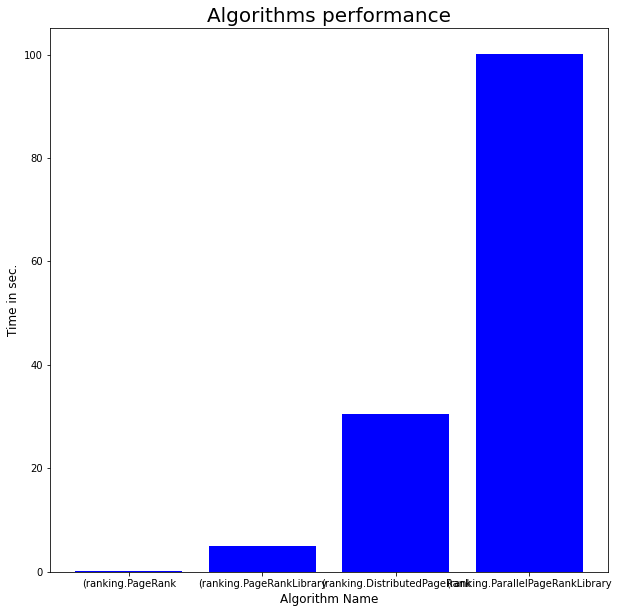

In [ ]:
import matplotlib.pyplot as plt

names = []
times = []
chars = "(),\n,"

f = open('/content/sample_data/part-00000','r+')
f1 = open('/content/sample_data/part-00000_1','r+')

testo=f.read()
f1.write('\n')
f1.write(testo)

for row in f1:
    row = row.replace(chars,"")
    row = row.split(',')
    names.append(row[0])
    row[1] = row[1].replace(")", "")
    times.append(float(row[1]))

f.close() 
f1.close()
plt.bar(names, times, color = 'b', label = 'Results')

plt.xlabel('Algorithm Name', fontsize = 12)
plt.ylabel('Time in sec.', fontsize = 12)

plt.title('Algorithms performance', fontsize = 20)

fig1=plt.gcf()
fig1.set_figwidth(10)
fig1.set_figheight(10)
plt.show()
fig1.savefig('result.png')

## Delete cluster

In [ ]:
!gcloud dataproc clusters delete single-node-cluster \
    --region=us-central1

The cluster 'single-node-cluster' and all attached disks will be deleted.

Do you want to continue (Y/n)?  Y

Waiting on operation [projects/scalaproject-343716/regions/us-central1/operations/76aedb1c-02d4-3143-a900-5492b5024b84].
Deleted [https://dataproc.googleapis.com/v1/projects/scalaproject-343716/regions/us-central1/clusters/single-node-cluster].


In [ ]:
!gcloud dataproc clusters delete standard-cluster \
    --region=us-central1

The cluster 'standard-cluster' and all attached disks will be deleted.

Do you want to continue (Y/n)?  Y

Waiting on operation [projects/scalaproject-343716/regions/us-central1/operations/64bd0a10-e89f-3eb0-9cb8-6e678a321c75].
Deleted [https://dataproc.googleapis.com/v1/projects/scalaproject-343716/regions/us-central1/clusters/standard-cluster].
